In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Concatenate, GlobalAvgPool2D, Lambda
from tensorflow.keras.models import Model

# pretrained model: ResNet50
from tensorflow.keras.applications import ResNet50, InceptionV3, EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess



from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight


In [3]:
def parse_spectrogram_and_metadata(melspec_path, split_path, metadata_path):
    # Load mel spectrograms
    melspec_dict = np.load(melspec_path, allow_pickle=True).item()

    # Load split and label info
    split_df = pd.read_csv(split_path)
    split_df['key'] = split_df['filename'].apply(lambda x: x.replace('.ogg', '').replace('/', '-'))
    split_df = split_df.set_index('key')

    # Load downsampled metadata
    meta_df = pd.read_csv(metadata_path)
    meta_df['key'] = meta_df['filename'].apply(lambda x: x.replace('.ogg', '').replace('/', '-'))
    meta_df = meta_df.set_index('key')

    X_img, X_meta, y, splits = [], [], [], []

    for key in meta_df.index:
        if key not in melspec_dict or key not in split_df.index:
            continue

        img = melspec_dict[key]
        info = split_df.loc[key]
        meta_row = meta_df.loc[key]

        metadata = np.array([
            float(meta_row['latitude']),
            float(meta_row['longitude']),
            float(meta_row['call']),
            float(meta_row['song/canto'])
        ], dtype=np.float32)

        X_img.append(img)
        X_meta.append(metadata)
        y.append(info['y_species_encoded'])
        splits.append(info['split'])

    return np.array(X_img), np.array(X_meta), np.array(y), np.array(splits)

In [4]:
def split_data(X_img, X_meta, y, splits):
    split_map = defaultdict(lambda: ([], [], []))

    for i, split in enumerate(splits):
        split_map[split][0].append(X_img[i])
        split_map[split][1].append(X_meta[i])
        split_map[split][2].append(y[i])

    def to_np(t): return tuple(map(np.array, t))
    return {k: to_np(v) for k, v in split_map.items()}

In [5]:
# data augmentation
def add_random_noise(mels, noise_factor=0.05):
    noise = noise_factor * np.random.randn(*mels.shape)
    return np.clip(mels + noise, 0.0, 1.0).astype(np.float32)

def time_mask(spec, max_width=8):
    t = np.random.randint(0, spec.shape[1] - max_width)
    width = np.random.randint(1, max_width)
    spec[:, t:t+width] = 0
    return spec

def freq_mask(spec, max_height=4):
    f = np.random.randint(0, spec.shape[0] - max_height)
    height = np.random.randint(1, max_height)
    spec[f:f+height, :] = 0
    return spec


def augment_spectrogram(spec):
    spec = add_random_noise(spec)
    spec = time_mask(spec)
    spec = freq_mask(spec)
    spec = spec.astype(np.float32)

    return spec

def image_augment(spec):
    spec = tf.image.random_brightness(spec, max_delta = .1)
    spec = tf.image.random_contrast(spec, .9, 1.1)

    return spec



In [6]:
X_img, X_meta, y, splits = parse_spectrogram_and_metadata(
    melspec_path= "../data/32/birdclef2025_melspec_5sec_32_32.npy",
    split_path= "../data/work_df_w_split_info.csv",
    metadata_path="../data/downsampled_metadata.csv"
)

In [7]:
# resizing image for inceptionv3
IMG_SIZE = 224

In [8]:
def preprocess_spec(img):
    img = tf.cast(img, tf.float32)
    img = img[..., tf.newaxis] # to get (32, 32, 1)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) #(224, 224, 1)
    img = tf.image.grayscale_to_rgb(img) # now (224, 224, 3)

    return img


In [9]:
def make_tf_dataset(X_img, X_meta, y, batch_size = 32, augment = False, shuffle = True):
    def map_fn(img, meta, label):
        if augment:
            # augment before resizing
            img = tf.numpy_function(augment_spectrogram, [img], tf.float32)
            img.set_shape([32, 32])

        img = preprocess_spec(img)
        
        img = resnet_preprocess(img) 

        # take out augmenting after resizing
        if augment:
            img = image_augment(img)

        return({"image": img, "metadata": meta}, tf.one_hot(label, num_classes))
    
    ds = tf.data.Dataset.from_tensor_slices((X_img, X_meta, y))
    if shuffle:
        ds = ds.shuffle(buffer_size = len(X_img))
        
    ds = ds.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)


    return ds

In [10]:
def preprocess_ds(ds):
    image = resnet_preprocess(ds["image"])
    metadata = ds["metadata"]
    label = ds["label"]

    return {"image": image, "metadata": metadata}, label

In [11]:
def build_resnet_model(img_shape, meta_features_num, num_classes,
                          fine_tune = False,
                          fine_tune_at = None):
    # image input
    img_input = Input(shape = img_shape, name = "image")

    x = Lambda(resnet_preprocess)(img_input)

    # base_model = ResNet50(include_top=False, weights = 'imagenet', input_tensor=img_input)
    base_model = ResNet50(include_top=False, weights = 'imagenet', input_tensor=x)

     # Fine-tune setup
    if fine_tune:
        base_model.trainable = True
        if fine_tune_at:
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False
    else:
        # freeze for initial training
        base_model.trainable = False

    x = GlobalAvgPool2D()(base_model.output)
    # added model3
    # x = Dense(64, activation = "relu")(x)
    # x = Dropout(.5)(x)

    # metadata input
    meta_input = Input(shape = (meta_features_num, ), name = "metadata")
    m = Dense(64, activation = "relu")(meta_input)
    m = Dropout(.3)(m)

    # now combining cnn & metadata
    combined = Concatenate()([x, m])
    combined = Dense(128, activation = "relu")(combined)
    combined = Dropout(.4)(combined)

    # added for model2
    combined = Dense(64, activation = "relu")(combined)
    combined = Dropout(.5)(combined)

    # added for model4
    combined = Dense(32, activation = "relu")(combined)
    combined = Dropout(.5)(combined)

    
    output = Dense(num_classes, activation = "softmax")(combined)

    model = Model(inputs = {"image": img_input, "metadata": meta_input}, outputs = output)

    # compile model
    model.compile(optimizer = "adam",
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])

    return model

In [12]:
# modified from Denvir's code

data_splits = split_data(X_img, X_meta, y, splits)

X_train_img, X_train_meta, y_train = data_splits['train']
X_val_img, X_val_meta, y_val = data_splits['val']
X_test_img, X_test_meta, y_test = data_splits['test']

# Omit adding channel dimension to spectrograms
# X_train_img = X_train_img[..., np.newaxis]  # becomes (259, 32, 32, 1)
# X_val_img = X_val_img[..., np.newaxis]
# X_test_img = X_test_img[..., np.newaxis]

X_train_img = X_train_img.astype(np.float32)
X_val_img = X_val_img.astype(np.float32)
X_test_img = X_test_img.astype(np.float32)

X_train_meta = X_train_meta.astype(np.float32)
X_val_meta = X_val_meta.astype(np.float32)
X_test_meta = X_test_meta.astype(np.float32)

y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)
y_test = y_test.astype(np.int32)

print(X_train_img.shape)  # --> (N, 256, 256, 1)
print(X_train_meta.shape) # --> (N, 4)
print(y_train.shape)      # --> (N,)

(259, 32, 32)
(259, 4)
(259,)


In [13]:
num_classes = len(np.unique(y))
print(num_classes)

4


In [14]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)
img_shape

(224, 224, 3)

In [15]:
meta_features_num = X_train_meta.shape[1]
meta_features_num

4

In [16]:
train_ds = make_tf_dataset(X_train_img, X_train_meta, y_train, augment=True, shuffle=True)
val_ds = make_tf_dataset(X_val_img, X_val_meta, y_val, augment=False, shuffle=False)
test_ds = make_tf_dataset(X_test_img, X_test_meta, y_test, augment=False, shuffle=False)

In [17]:
y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_val_oh = to_categorical(y_val, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

In [18]:
scaler = StandardScaler()
X_train_meta = scaler.fit_transform(X_train_meta)
X_val_meta = scaler.transform(X_val_meta)
X_test_meta = scaler.transform(X_test_meta)

In [19]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [47]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

In [48]:
model_base = build_resnet_model(img_shape=img_shape,
                              meta_features_num=meta_features_num,
                              num_classes=num_classes)

In [49]:
# train
model_base.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    callbacks = callbacks,
    verbose = 1    
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2238 - loss: 1.6365

9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.2258 - loss: 1.6316 - val_accuracy: 0.2740 - val_loss: 1.3580
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2482 - loss: 1.4322

9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 7s/step - accuracy: 0.2516 - loss: 1.4284 - val_accuracy: 0.2740 - val_loss: 1.2946
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3845 - loss: 1.2649

9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.3850 - loss: 1.2656 - val_accuracy: 0.4932 - val_loss: 1.2256
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4788 - loss: 1.1766

9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4788 - loss: 1.1777 - val_accuracy: 0.5205 - val_loss: 1.1771
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5616 - loss: 1.1314

9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.5607 - loss: 1.1314 - val_accuracy: 0.5479 - val_loss: 1.1400
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5551 - loss: 1.1090

9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5529 - loss: 1.1096 - val_accuracy: 0.5479 - val_loss: 1.1130
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5884 - loss: 1.0180

9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.5848 - loss: 1.0193 - val_accuracy: 0.5342 - val_loss: 1.0742
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5507 - loss: 1.0565

9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.5570 - loss: 1.0497 - val_accuracy: 0.6986 - val_loss: 1.0600
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.6192 - loss: 0.9679 - val_accuracy: 0.5068 - val_loss: 1.0644
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6038 - loss: 0.9167

9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6018 - loss: 0.9210 - val_accuracy: 0.5068 - val_loss: 1.0392
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6527 - loss: 0.9395

9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.6534 - loss: 0.9347 - val_accuracy: 0.5068 - val_loss: 1.0382
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.6110 - loss: 0.9380 - val_accuracy: 0.5068 - val_loss: 1.0469
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6551 - loss: 0.8633 - val_accuracy: 0.5068 - val_loss: 1.0482
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5751 - loss: 0.9373 - val_accuracy: 0.5068 - val_loss: 1.0458
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5846 - loss: 0.8634 - val_accuracy: 0.5205 - val_loss: 1.0792
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6305 - loss: 0.8769 - val_accuracy: 0.6986 - val_loss: 1.0572
Epoch 17/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6589 - loss: 0.9237 - val_accuracy: 0.5068 - val_loss: 1.0639
Epoch 18/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6354 - loss: 0.8651 - val_accuracy: 0.5342 - val_loss: 1.0385
Epoch 19/50


In [50]:
test_loss, test_acc = model_base.evaluate(test_ds)
print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2f}")

val_loss, val_acc = model_base.evaluate(val_ds)
print(f"validation loss: {test_loss:.4f}, validation accuracy: {test_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5650 - loss: 0.8831
test loss: 0.84, test accuracy: 0.54
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5581 - loss: 1.0619
validation loss: 0.8383, validation accuracy: 0.5441


In [51]:
# Get predicted class indices
y_pred_prob = model_base.predict(test_ds)
y_pred = y_pred_prob.argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
              precision    recall  f1-score   support

           0       0.31      0.85      0.46        13
           1       0.83      0.62      0.71        16
           2       0.00      0.00      0.00        19
           3       0.76      0.80      0.78        20

    accuracy                           0.54        68
   macro avg       0.48      0.57      0.49        68
weighted avg       0.48      0.54      0.49        68



/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is il

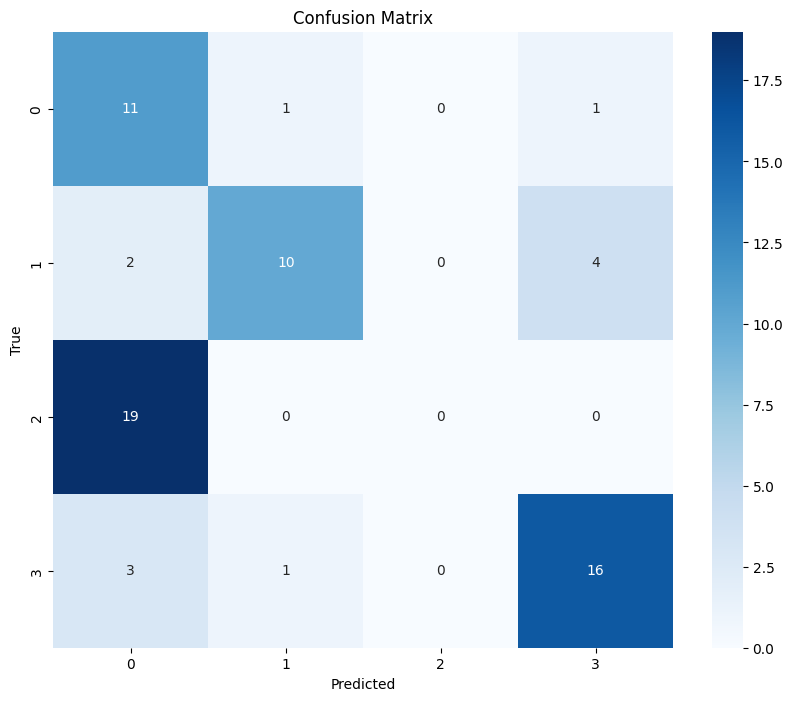

In [52]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# added a layer in the model
model2 = build_resnet_model(img_shape=img_shape,
                              meta_features_num=meta_features_num,
                              num_classes=num_classes)

In [55]:
# train
model2.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    callbacks = callbacks,
    verbose = 1    
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.2316 - loss: 1.7868 - val_accuracy: 0.2603 - val_loss: 1.3839
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.2187 - loss: 1.4840 - val_accuracy: 0.2329 - val_loss: 1.3812
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2460 - loss: 1.4355 - val_accuracy: 0.3973 - val_loss: 1.3697
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2676 - loss: 1.4356 - val_accuracy: 0.4110 - val_loss: 1.3744
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.2775 - loss: 1.4126 - val_accuracy: 0.2603 - val_loss: 1.3616
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2925 - loss: 1.4001 - val_accuracy: 0.2740 - val_loss: 1.3619
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2563 - loss: 1.4057 - val_accuracy: 0.5479 - val_loss: 1.3419
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.3441 - loss: 1.3395 - val_accuracy: 0.5342 - val_loss: 1.3314
Epoch 9/

9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.5306 - loss: 1.0068 - val_accuracy: 0.6575 - val_loss: 1.0359
Epoch 29/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5320 - loss: 1.0086 - val_accuracy: 0.5068 - val_loss: 1.0635
Epoch 30/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.6069 - loss: 0.8968 - val_accuracy: 0.5068 - val_loss: 1.0797
Epoch 31/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6140 - loss: 0.9671 - val_accuracy: 0.6164 - val_loss: 1.0714
Epoch 32/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6147 - loss: 0.9172 - val_accuracy: 0.5342 - val_loss: 1.0970
Epoch 33/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.5719 - loss: 0.9814 - val_accuracy: 0.6164 - val_loss: 1.0964
Epoch 34/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6221 - loss: 0.9692 - val_accuracy: 0.5753 - val_loss: 1.0803
Epoch 35/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5705 - loss: 0.9302 - val_accuracy: 0.5068 - val_loss: 1.0731
Epoch 36/50


In [57]:
# Get predicted class indices
y_pred_prob = model2.predict(test_ds)
y_pred = y_pred_prob.argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred))

2/3 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x36caf9090> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
              precision    recall  f1-score   support

           0       0.83      0.38      0.53        13
           1       0.85      0.69      0.76        16
           2       0.61      1.00      0.76        19
           3       0.89      0.80      0.84        20

    accuracy                           0.75        68
   macro avg       0.80      0.72      0.72        68
weighted avg       0.79      0.75      0.74        68



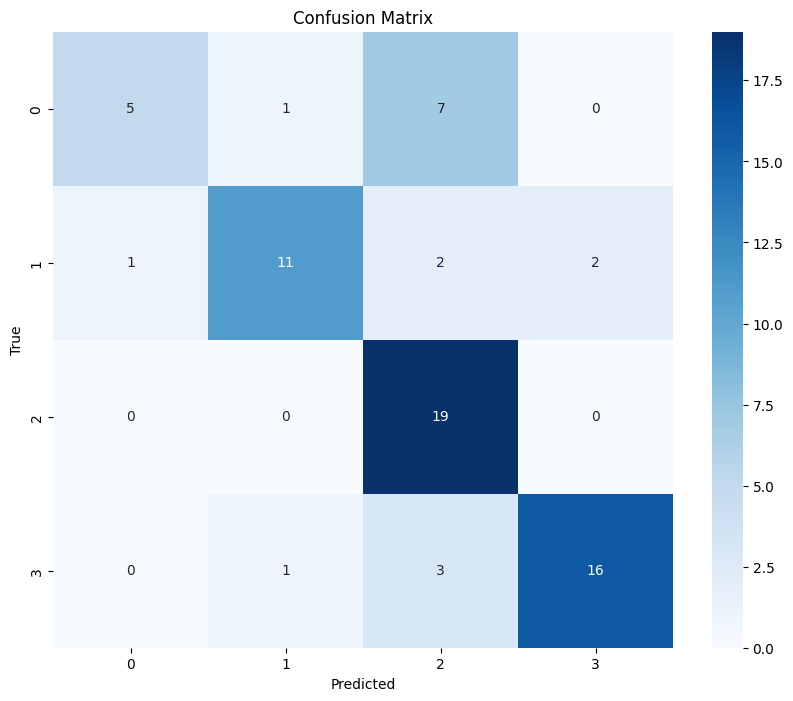

In [58]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [63]:
model2.save("model2.keras")

In [71]:
model3 = build_resnet_model(img_shape=img_shape,
                              meta_features_num=meta_features_num,
                              num_classes=num_classes)

In [72]:
model3.fit(train_ds,
    validation_data = val_ds,
    epochs = 50,
    callbacks = callbacks,
    verbose = 1)

Epoch 1/50


9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.2367 - loss: 1.8731 - val_accuracy: 0.1918 - val_loss: 1.3728
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.2822 - loss: 1.4028 - val_accuracy: 0.4658 - val_loss: 1.3258
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3252 - loss: 1.3462 - val_accuracy: 0.4795 - val_loss: 1.3011
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4102 - loss: 1.2608 - val_accuracy: 0.5616 - val_loss: 1.2569
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4133 - loss: 1.2584 - val_accuracy: 0.5753 - val_loss: 1.2041
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5658 - loss: 1.1645 - val_accuracy: 0.6027 - val_loss: 1.1640
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5655 - loss: 1.0891 - val_accuracy: 0.5753 - val_loss: 1.1156
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5867 - loss: 1.0849 - val_accuracy: 0.5753 - val_loss: 1.0797
Epoch 9/50
9/9 ━━━━

In [73]:
test_loss, test_acc = model3.evaluate(test_ds)
print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2f}")

val_loss, val_acc = model3.evaluate(val_ds)
print(f"validation loss: {test_loss:.4f}, validation accuracy: {test_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6880 - loss: 0.8420
test loss: 0.80, test accuracy: 0.74
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5367 - loss: 1.0675
validation loss: 0.7951, validation accuracy: 0.7353


In [74]:
# Get predicted class indices
y_pred_prob = model3.predict(test_ds)
y_pred = y_pred_prob.argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
              precision    recall  f1-score   support

           0       1.00      0.38      0.56        13
           1       0.83      0.62      0.71        16
           2       0.63      1.00      0.78        19
           3       0.76      0.80      0.78        20

    accuracy                           0.74        68
   macro avg       0.81      0.70      0.71        68
weighted avg       0.79      0.74      0.72        68



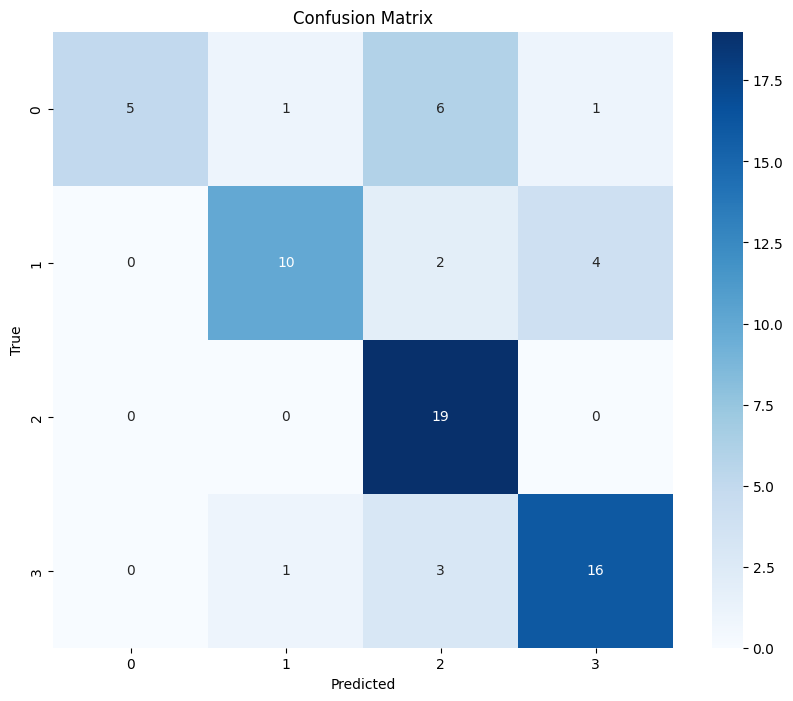

In [75]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [82]:
model3.save("model3.keras")

In [77]:
model4 = build_resnet_model(img_shape=img_shape,
                              meta_features_num=meta_features_num,
                              num_classes=num_classes)

In [78]:
model4.fit(train_ds,
    validation_data = val_ds,
    epochs = 50,
    callbacks = callbacks,
    verbose = 1)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.2823 - loss: 2.0540 - val_accuracy: 0.2466 - val_loss: 1.4007
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.2515 - loss: 1.5526 - val_accuracy: 0.2329 - val_loss: 1.3888
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2796 - loss: 1.4939 - val_accuracy: 0.3014 - val_loss: 1.3857
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3055 - loss: 1.4516 - val_accuracy: 0.2466 - val_loss: 1.3814
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.2777 - loss: 1.4158 - val_accuracy: 0.2329 - val_loss: 1.3836
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.2833 - loss: 1.3889 - val_accuracy: 0.2329 - val_loss: 1.3837
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2423 - loss: 1.4121 - val_accuracy: 0.2329 - val_loss: 1.3816
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2624 - loss: 1.4174 - val_accuracy: 0.2466 - val_loss: 1.3813
Epoch 9/

In [79]:
test_loss, test_acc = model4.evaluate(test_ds)
print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2f}")

val_loss, val_acc = model4.evaluate(val_ds)
print(f"validation loss: {test_loss:.4f}, validation accuracy: {test_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5841 - loss: 0.9854
test loss: 0.93, test accuracy: 0.56
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5874 - loss: 1.1176
validation loss: 0.9284, validation accuracy: 0.5588


In [80]:
# Get predicted class indices
y_pred_prob = model4.predict(test_ds)
y_pred = y_pred_prob.argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
              precision    recall  f1-score   support

           0       0.33      0.92      0.49        13
           1       0.83      0.62      0.71        16
           2       0.00      0.00      0.00        19
           3       0.80      0.80      0.80        20

    accuracy                           0.56        68
   macro avg       0.49      0.59      0.50        68
weighted avg       0.50      0.56      0.50        68



/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is il

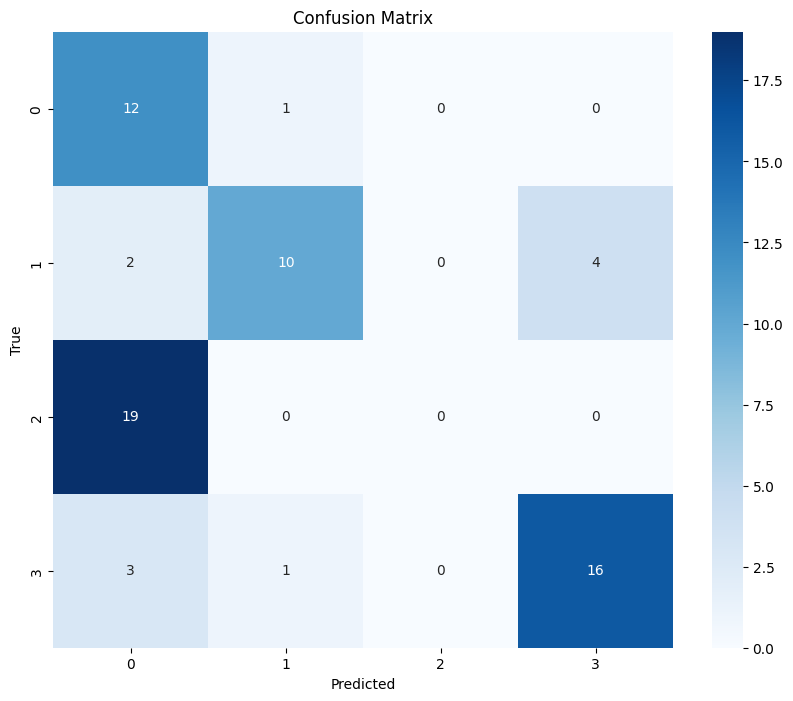

In [81]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()